# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd 
import random as rn

# tensorflow
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Chart
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
import glob
from pathlib import Path

from skimage import color, exposure
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import os
import cv2

# Setting the same seed for repeatability

seed = 0

np.random.seed(seed) 
rn.seed(seed)
tfr.set_seed(seed)

# Display graphs in a Jupyter
%matplotlib inline

print("Imported")

Imported


#Loading data

In [ ]:
cd drive/MyDrive/Colab Notebooks/Covid_detection

/content/drive/MyDrive/Colab Notebooks/Covid_detection


In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Covid_detection'

In [ ]:
pneumonia_bacterial = np.load('Data/pneumonia_bacterial.npy')
covid = np.load('Data/covid.npy')
normal = np.load('Data/normal.npy')
pneumonia_viral = np.load('Data/pneumonia_viral.npy')

In [ ]:
pneumonia_bacterial = pneumonia_bacterial.reshape(-1, 256*256)
covid = covid.reshape(-1, 256*256)
normal = normal.reshape(-1, 256*256)
pneumonia_viral = pneumonia_viral.reshape(-1, 256*256)

In [ ]:
def f(x):
    if x == 0:
        return 'normal'
    elif x == 1:
        return 'pneumonia_bacterial'
    elif x == 2:
        return 'pneumonia_viral'
    elif x == 3:
        return 'covid'

In [ ]:
df0 = pd.DataFrame([(img,0) for img in normal],columns=['img', 'label'])
df1 = pd.DataFrame([(img,1) for img in pneumonia_bacterial],columns=['img', 'label'])
df2 = pd.DataFrame([(img,2) for img in pneumonia_viral],columns=['img', 'label'])
df3 = pd.DataFrame([(img,3) for img in covid],columns=['img', 'label'])

del pneumonia_bacterial, normal, covid, pneumonia_viral

In [ ]:
df = pd.concat((df0,df1,df2,df3)).reset_index()
del df0, df1, df2, df3

In [ ]:
X = np.stack(df['img'])
y = df['label']
del df

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.01, random_state=seed)
del X, y

# MLP

## Preprocessing

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:
num_pixels = X_train.shape[1]
num_pixels

65536

In [ ]:
num_classes = y_train.shape[1]
num_classes

4

In [ ]:
def draw_learning_curve(history, keys=['accuracy', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()

In [ ]:
def get_callback(num):
    return [ 
        EarlyStopping(monitor = 'loss', patience = 6), 
        ReduceLROnPlateau(monitor = 'loss', patience = 3), 
        ModelCheckpoint('models/model.best{}.hdf5'.format(num),monitor='loss', save_best_only=True) # saving the best model
    ]

## First model

In [ ]:
callbacks = get_callback(1)

In [ ]:
def get_mlp():
    
    return Sequential([
        #input layer is automatic generation by keras
        
        #hidden layer
        Dense(512, input_dim = num_pixels, activation='relu'),
        
        Dropout(0.3),

        #output layer
        Dense(num_classes, activation='softmax')
    ])

In [ ]:
model = get_mlp()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               33554944  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 33,556,996
Trainable params: 33,556,996
Non-trainable params: 0
_________________________________________________________________


In [ ]:
learning_history = model.fit(X_train, y_train,
          batch_size = 256, epochs = 60, verbose = 2,
          callbacks = callbacks,
          validation_data=(X_test, y_test));

Epoch 1/60
29/29 - 6s - loss: 30.5594 - accuracy: 0.4383 - val_loss: 2.9876 - val_accuracy: 0.6264
Epoch 2/60
29/29 - 7s - loss: 2.2936 - accuracy: 0.6259 - val_loss: 0.9873 - val_accuracy: 0.4195
Epoch 3/60
29/29 - 11s - loss: 0.8329 - accuracy: 0.6661 - val_loss: 0.6327 - val_accuracy: 0.7651
Epoch 4/60
29/29 - 11s - loss: 0.6789 - accuracy: 0.7328 - val_loss: 0.6847 - val_accuracy: 0.7192
Epoch 5/60
29/29 - 9s - loss: 0.6697 - accuracy: 0.7388 - val_loss: 0.5613 - val_accuracy: 0.7870
Epoch 6/60
29/29 - 10s - loss: 0.6221 - accuracy: 0.7523 - val_loss: 0.5748 - val_accuracy: 0.7781
Epoch 7/60
29/29 - 10s - loss: 0.6022 - accuracy: 0.7679 - val_loss: 0.5724 - val_accuracy: 0.7586
Epoch 8/60
29/29 - 10s - loss: 0.5707 - accuracy: 0.7673 - val_loss: 0.5750 - val_accuracy: 0.7711
Epoch 9/60
29/29 - 10s - loss: 0.5636 - accuracy: 0.7703 - val_loss: 0.5358 - val_accuracy: 0.7860
Epoch 10/60
29/29 - 1s - loss: 0.5751 - accuracy: 0.7666 - val_loss: 0.5207 - val_accuracy: 0.7731
Epoch 11/60


In [ ]:
model = load_model('models/model.best1.hdf5')

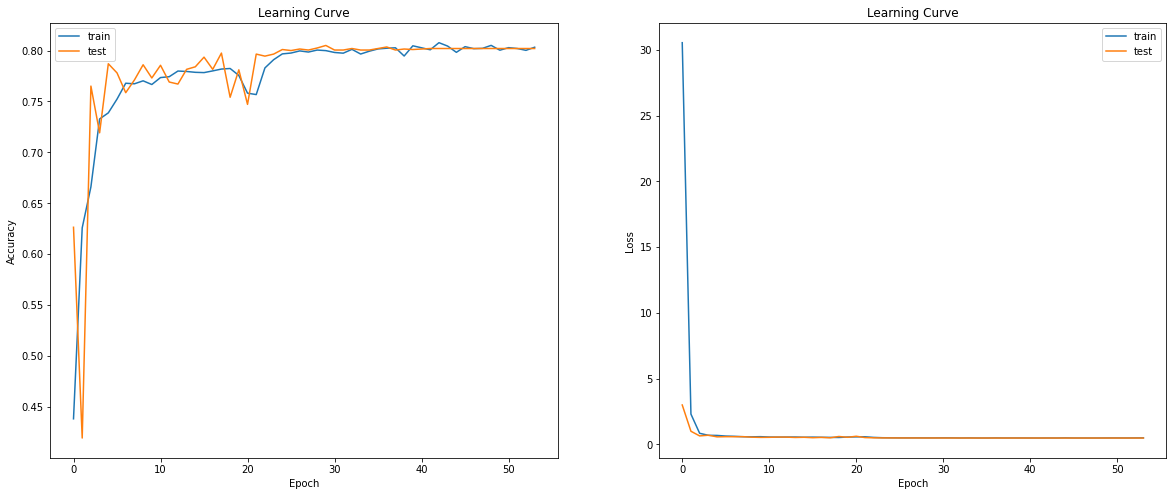

In [ ]:
draw_learning_curve(learning_history)

# Evalute model on train data

In [ ]:
Result = pd.DataFrame()

In [ ]:
scores = []

In [ ]:
score = model.evaluate(X_train, y_train, verbose = 0)
print('Train loss: {}%'.format(score[0] * 100))
print('Train accuracy: {}%'.format(score[1] * 100))

print("Train Error: %.2f%%" % (100 - score[1] * 100))

Train loss: 42.81558692455292%
Train accuracy: 82.05235600471497%
Train Error: 17.95%


In [ ]:
score_train = {'Train loss':score[0] * 100, 'Train accuracy':score[1] * 100, 'Train Error':(100 - score[1] * 100)}

In [ ]:
scores = score_train

# Evalute model on test data

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("Test Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 47.15811312198639%
Test accuracy: 80.1995038986206%
Test Error: 19.80%


In [ ]:
score_test = {'Test loss':score[0] * 100, 'Test accuracy':score[1] * 100, 'Test Error':(100 - score[1] * 100)}

In [ ]:
scores.update(score_test)

# Evalute model on validation data

In [ ]:
score = model.evaluate(X_val, y_val, verbose = 0)
print('Valid loss: {}%'.format(score[0] * 100))
print('Valid accuracy: {}%'.format(score[1] * 100))

print("Valid Error: %.2f%%" % (100 - score[1] * 100))

Valid loss: 44.728606939315796%
Valid accuracy: 76.1904776096344%
Valid Error: 23.81%


In [ ]:
score_valid = {'Valid loss':score[0] * 100, 'Valid accuracy':score[1] * 100, 'Valid Error':(100 - score[1] * 100)}

In [ ]:
scores.update(score_valid)

# Adding the result to the table

In [ ]:
scores

{'Test Error': 19.800496101379395,
 'Test accuracy': 80.1995038986206,
 'Test loss': 47.15811312198639,
 'Train Error': 17.947643995285034,
 'Train accuracy': 82.05235600471497,
 'Train loss': 42.81558692455292,
 'Valid Error': 23.8095223903656,
 'Valid accuracy': 76.1904776096344,
 'Valid loss': 44.728606939315796}

In [ ]:
score = pd.DataFrame(scores,index = ['Simple MLP'])

In [ ]:
score.to_csv('models/score.csv')

In [ ]:
score

,Train loss,Train accuracy,Train Error,Test loss,Test accuracy,Test Error,Valid loss,Valid accuracy,Valid Error
Simple MLP,42.815587,82.052356,17.947644,47.158113,80.199504,19.800496,44.728607,76.190478,23.809522
